# Customizing embeddings

This notebook demonstrates one way to customize OpenAI embeddings to a particular task.

The input is training data in the form of [text_1, text_2, label] where label is +1 if the pairs are similar and -1 if the pairs are dissimilar.

The output is a matrix that you can use to multiply your embeddings. The product of this multiplication is a 'custom embedding' that will better emphasize aspects of the text relevant to your use case. In binary classification use cases, we've seen error rates drop by as much as 50%.

In the following example, I use 1,000 sentence pairs picked from the SNLI corpus. Each pair of sentences are logically entailed (i.e., one implies the other). These pairs are our positives (label = 1). We generate synthetic negatives by combining sentences from different pairs, which are presumed to not be logically entailed (label = -1).

For a clustering use case, you can generate positives by creating pairs from texts in the same clusters and generate negatives by creating pairs from sentences in different clusters.

With other data sets, we have seen decent improvement with as little as ~100 training examples. Of course, performance will be better with  more examples.

In [4]:
pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 MB 20.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


# 0. Imports

In [5]:
# imports
from typing import List, Tuple  # for type hints

import numpy as np  # for manipulating arrays
import pandas as pd  # for manipulating data in dataframes
import pickle  # for saving the embeddings cache
import plotly.express as px  # for plots
import random  # for generating run IDs
from sklearn.model_selection import train_test_split  # for splitting train & test data
import torch  # for matrix optimization

from openai.embeddings_utils import get_embedding, cosine_similarity  # for embeddings


## 1. Inputs

Most inputs are here. The key things to change are where to load your datset from, where to save a cache of embeddings to, and which embedding engine you want to use.

Depending on how your data is formatted, you'll want to rewrite the process_input_data function.

In [2]:
# input parameters
embedding_cache_path = "data/snli_embedding_cache.pkl"  # embeddings will be saved/loaded here
default_embedding_engine = "babbage-similarity"  # text-embedding-ada-002 is recommended
num_pairs_to_embed = 1000  # 1000 is arbitrary
local_dataset_path = "data/snli_1.0_train_2k.csv"  # download from: https://nlp.stanford.edu/projects/snli/


def process_input_data(df: pd.DataFrame) -> pd.DataFrame:
    # you can customize this to preprocess your own dataset
    # output should be a dataframe with 3 columns: text_1, text_2, label (1 for similar, -1 for dissimilar)
    df["label"] = df["gold_label"]
    df = df[df["label"].isin(["entailment"])]
    df["label"] = df["label"].apply(lambda x: {"entailment": 1, "contradiction": -1}[x])
    df = df.rename(columns={"sentence1": "text_1", "sentence2": "text_2"})
    df = df[["text_1", "text_2", "label"]]
    df = df.head(num_pairs_to_embed)
    return df


## 2. Load and process input data

In [3]:
# load data
df = pd.read_csv(local_dataset_path)

# process input data
df = process_input_data(df)  # this demonstrates training data containing only positives

# view data
df.head()


/var/folders/r4/x3kdvs816995fnnph2gdpwp40000gn/T/ipykernel_17509/1977422881.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = df["label"].apply(lambda x: {"entailment": 1, "contradiction": -1}[x])


,text_1,text_2,label
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
4,Children smiling and waving at camera,There are children present,1
7,A boy is jumping on skateboard in the middle o...,The boy does a skateboarding trick.,1
14,Two blond women are hugging one another.,There are women showing affection.,1
17,"A few people in a restaurant setting, one of t...",The diners are at a restaurant.,1


## 3. Split data into training test sets

Note that it's important to split data into training and test sets *before* generating synethetic negatives or positives. You don't want any text strings in the training data to show up in the test data. If there's contamination, the test metrics will look better than they'll actually be in production.

In [4]:
# split data into train and test sets
test_fraction = 0.5  # 0.5 is fairly arbitrary
random_seed = 123  # random seed is arbitrary, but is helpful in reproducibility
train_df, test_df = train_test_split(
    df, test_size=test_fraction, stratify=df["label"], random_state=random_seed
)
train_df.loc[:, "dataset"] = "train"
test_df.loc[:, "dataset"] = "test"


## 4. Generate synthetic negatives

This is another piece of the code that you will need to modify to match your use case.

If you have data with positives and negatives, you can skip this section.

If you have data with only positives, you can mostly keep it as is, where it generates negatives only.

If you have multiclass data, you will want to generate both positives and negatives. The positives can be pairs of text that share labels, and the negatives can be pairs of text that do not share labels.

The final output should be a dataframe with text pairs, where each pair is labeled -1 or 1.

In [5]:
# generate negatives
def dataframe_of_negatives(dataframe_of_positives: pd.DataFrame) -> pd.DataFrame:
    """Return dataframe of negative pairs made by combining elements of positive pairs."""
    texts = set(dataframe_of_positives["text_1"].values) | set(
        dataframe_of_positives["text_2"].values
    )
    all_pairs = {(t1, t2) for t1 in texts for t2 in texts if t1 < t2}
    positive_pairs = set(
        tuple(text_pair)
        for text_pair in dataframe_of_positives[["text_1", "text_2"]].values
    )
    negative_pairs = all_pairs - positive_pairs
    df_of_negatives = pd.DataFrame(list(negative_pairs), columns=["text_1", "text_2"])
    df_of_negatives["label"] = -1
    return df_of_negatives


In [6]:
negatives_per_positive = (
    1  # it will work at higher values too, but more data will be slower
)
# generate negatives for training dataset
train_df_negatives = dataframe_of_negatives(train_df)
train_df_negatives["dataset"] = "train"
# generate negatives for test dataset
test_df_negatives = dataframe_of_negatives(test_df)
test_df_negatives["dataset"] = "test"
# sample negatives and combine with positives
train_df = pd.concat(
    [
        train_df,
        train_df_negatives.sample(
            n=len(train_df) * negatives_per_positive, random_state=random_seed
        ),
    ]
)
test_df = pd.concat(
    [
        test_df,
        test_df_negatives.sample(
            n=len(test_df) * negatives_per_positive, random_state=random_seed
        ),
    ]
)

df = pd.concat([train_df, test_df])


## 5. Calculate embeddings and cosine similarities

Here, I create a cache to save the embeddings. This is handy so that you don't have to pay again if you want to run the code again.

In [7]:
# establish a cache of embeddings to avoid recomputing
# cache is a dict of tuples (text, engine) -> embedding
try:
    with open(embedding_cache_path, "rb") as f:
        embedding_cache = pickle.load(f)
except FileNotFoundError:
    precomputed_embedding_cache_path = "https://cdn.openai.com/API/examples/data/snli_embedding_cache.pkl"
    embedding_cache = pd.read_pickle(precomputed_embedding_cache_path)


# this function will get embeddings from the cache and save them there afterward
def get_embedding_with_cache(
    text: str,
    engine: str = default_embedding_engine,
    embedding_cache: dict = embedding_cache,
    embedding_cache_path: str = embedding_cache_path,
) -> list:
    print(f"Getting embedding for {text}")
    if (text, engine) not in embedding_cache.keys():
        # if not in cache, call API to get embedding
        embedding_cache[(text, engine)] = get_embedding(text, engine)
        # save embeddings cache to disk after each update
        with open(embedding_cache_path, "wb") as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    return embedding_cache[(text, engine)]


# create column of embeddings
for column in ["text_1", "text_2"]:
    df[f"{column}_embedding"] = df[column].apply(get_embedding_with_cache)

# create column of cosine similarity between embeddings
df["cosine_similarity"] = df.apply(
    lambda row: cosine_similarity(row["text_1_embedding"], row["text_2_embedding"]),
    axis=1,
)


Getting embedding for Three wheelchair basketball players wearing team uniforms are attempting to reach the descending basketball with other players in the background.
Getting embedding for A man with a beard, wearing a red shirt with gray sleeves and work gloves, pulling on a rope.
Getting embedding for A person in a red coat and a running black and brown dog.
Getting embedding for Five men, one wearing a white shirt standing on something, hanging up a picture of a child.
Getting embedding for A busy city that looks like New York City.
Getting embedding for People on bicycles waiting at an intersection.
Getting embedding for Emergency personnel looking into the back of a car.
Getting embedding for Outside by the trees, a woman wearing jeans and red jacket throws something for a German shepherd to chase.
Getting embedding for A man with a red shirt is watching another man who is standing on top of a attached cart filled to the top.
Getting embedding for High fashion ladies wait outside

## 6. Plot distribution of cosine similarity

Here we measure similarity of text using cosine similarity. In our experience, most distance functions (L1, L2, cosine similarity) all work about the same. Note that our embeddings are already normalized to length 1, so cosine similarity is equivalent to dot product.

The graphs show how much the overlap there is between the distribution of cosine similarities for similar and dissimilar pairs. If there is a high amount of overlap, that means there are some dissimilar pairs with greater cosine similarity than some similar pairs.

The accuracy I compute is the accuracy of a simple rule that predicts 'similar (1)' if the cosine similarity is above some threshold X and otherwise predicts 'dissimilar (0)'.

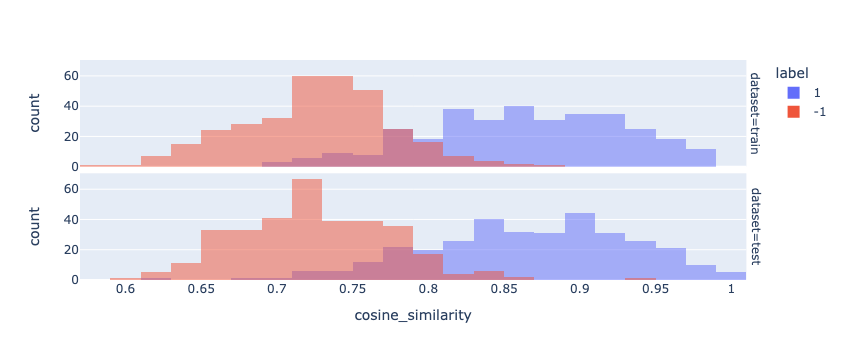

train accuracy: 89.1% ± 2.4%
test accuracy: 88.8% ± 2.4%


In [8]:
# calculate accuracy (and its standard error) of predicting label=1 if similarity>x
# x is optimized by sweeping from -1 to 1 in steps of 0.01
def accuracy_and_se(cosine_similarity: float, labeled_similarity: int) -> Tuple[float]:
    accuracies = []
    for threshold_thousandths in range(-1000, 1000, 1):
        threshold = threshold_thousandths / 1000
        total = 0
        correct = 0
        for cs, ls in zip(cosine_similarity, labeled_similarity):
            total += 1
            if cs > threshold:
                prediction = 1
            else:
                prediction = -1
            if prediction == ls:
                correct += 1
        accuracy = correct / total
        accuracies.append(accuracy)
    a = max(accuracies)
    n = len(cosine_similarity)
    standard_error = (a * (1 - a) / n) ** 0.5  # standard error of binomial sqrt(p*(1-p))
    return a, standard_error


# check that training and test sets are balanced
px.histogram(
    df,
    x="cosine_similarity",
    color="label",
    barmode="overlay",
    width=500,
    facet_row="dataset",
).show()

for dataset in ["train", "test"]:
    data = df[df["dataset"] == dataset]
    a, se = accuracy_and_se(data["cosine_similarity"], data["label"])
    print(f"{dataset} accuracy: {a:0.1%} ± {1.96 * se:0.1%}")


## 7. Optimize the matrix using the training data provided

In [9]:
# ?????
def embedding_multiplied_by_matrix(
    embedding: List[float], matrix: torch.tensor
) -> np.array:
    embedding_tensor = torch.tensor(embedding).float()
    modified_embedding = embedding_tensor @ matrix
    modified_embedding = modified_embedding.detach().numpy()
    return modified_embedding


# compute custom embeddings and new cosine similarities
def apply_matrix_to_embeddings_dataframe(matrix: torch.tensor, df: pd.DataFrame):
    for column in ["text_1_embedding", "text_2_embedding"]:
        df[f"{column}_custom"] = df[column].apply(
            lambda x: embedding_multiplied_by_matrix(x, matrix)
        )
    df["cosine_similarity_custom"] = df.apply(
        lambda row: cosine_similarity(
            row["text_1_embedding_custom"], row["text_2_embedding_custom"]
        ),
        axis=1,
    )


In [10]:
def optimize_matrix(
    modified_embedding_length: int = 2048,  # in my brief experimentation, bigger was better (2048 is length of babbage encoding)
    batch_size: int = 100,
    max_epochs: int = 100,
    learning_rate: float = 100.0,  # seemed to work best when similar to batch size - feel free to try a range of values
    dropout_fraction: float = 0.0,  # in my testing, dropout helped by a couple percentage points (definitely not necessary)
    df: pd.DataFrame = df,
    print_progress: bool = True,
    save_results: bool = True,
) -> torch.tensor:
    """Return matrix optimized to minimize loss on training data."""
    run_id = random.randint(0, 2 ** 31 - 1)  # (range is arbitrary)
    # convert from dataframe to torch tensors
    # e is for embedding, s for similarity label
    def tensors_from_dataframe(
        df: pd.DataFrame,
        embedding_column_1: str,
        embedding_column_2: str,
        similarity_label_column: str,
    ) -> Tuple[torch.tensor]:
        e1 = np.stack(np.array(df[embedding_column_1].values))
        e2 = np.stack(np.array(df[embedding_column_2].values))
        s = np.stack(np.array(df[similarity_label_column].astype("float").values))

        e1 = torch.from_numpy(e1).float()
        e2 = torch.from_numpy(e2).float()
        s = torch.from_numpy(s).float()

        return e1, e2, s

    e1_train, e2_train, s_train = tensors_from_dataframe(
        df[df["dataset"] == "train"], "text_1_embedding", "text_2_embedding", "label"
    )
    e1_test, e2_test, s_test = tensors_from_dataframe(
        df[df["dataset"] == "test"], "text_1_embedding", "text_2_embedding", "label"
    )

    # create dataset and loader
    dataset = torch.utils.data.TensorDataset(e1_train, e2_train, s_train)
    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    # define model (similarity of projected embeddings)
    def model(embedding_1, embedding_2, matrix, dropout_fraction=dropout_fraction):
        e1 = torch.nn.functional.dropout(embedding_1, p=dropout_fraction)
        e2 = torch.nn.functional.dropout(embedding_2, p=dropout_fraction)
        modified_embedding_1 = e1 @ matrix  # @ is matrix multiplication
        modified_embedding_2 = e2 @ matrix
        similarity = torch.nn.functional.cosine_similarity(
            modified_embedding_1, modified_embedding_2
        )
        return similarity

    # define loss function to minimize
    def mse_loss(predictions, targets):
        difference = predictions - targets
        return torch.sum(difference * difference) / difference.numel()

    # initialize projection matrix
    embedding_length = len(df["text_1_embedding"].values[0])
    matrix = torch.randn(
        embedding_length, modified_embedding_length, requires_grad=True
    )

    epochs, types, losses, accuracies, matrices = [], [], [], [], []
    for epoch in range(1, 1 + max_epochs):
        # iterate through training dataloader
        for a, b, actual_similarity in train_loader:
            # generate prediction
            predicted_similarity = model(a, b, matrix)
            # get loss and perform backpropagation
            loss = mse_loss(predicted_similarity, actual_similarity)
            loss.backward()
            # update the weights
            with torch.no_grad():
                matrix -= matrix.grad * learning_rate
                # set gradients to zero
                matrix.grad.zero_()
        # calculate test loss
        test_predictions = model(e1_test, e2_test, matrix)
        test_loss = mse_loss(test_predictions, s_test)

        # compute custom embeddings and new cosine similarities
        apply_matrix_to_embeddings_dataframe(matrix, df)

        # calculate test accuracy
        for dataset in ["train", "test"]:
            data = df[df["dataset"] == dataset]
            a, se = accuracy_and_se(data["cosine_similarity_custom"], data["label"])

            # record results of each epoch
            epochs.append(epoch)
            types.append(dataset)
            losses.append(loss.item() if dataset == "train" else test_loss.item())
            accuracies.append(a)
            matrices.append(matrix.detach().numpy())

            # optionally print accuracies
            if print_progress is True:
                print(
                    f"Epoch {epoch}/{max_epochs}: {dataset} accuracy: {a:0.1%} ± {1.96 * se:0.1%}"
                )

    data = pd.DataFrame(
        {"epoch": epochs, "type": types, "loss": losses, "accuracy": accuracies}
    )
    data["run_id"] = run_id
    data["modified_embedding_length"] = modified_embedding_length
    data["batch_size"] = batch_size
    data["max_epochs"] = max_epochs
    data["learning_rate"] = learning_rate
    data["dropout_fraction"] = dropout_fraction
    data[
        "matrix"
    ] = matrices  # saving every single matrix can get big; feel free to delete/change
    if save_results is True:
        data.to_csv(f"{run_id}_optimization_results.csv", index=False)

    return data


In [11]:
# example hyperparameter search
# I recommend starting with max_epochs=10 while initially exploring
results = []
max_epochs = 30
dropout_fraction = 0.2
for batch_size, learning_rate in [(10, 10), (100, 100), (1000, 1000)]:
    result = optimize_matrix(
        batch_size=batch_size,
        learning_rate=learning_rate,
        max_epochs=max_epochs,
        dropout_fraction=dropout_fraction,
        save_results=False,
    )
    results.append(result)


Epoch 1/30: train accuracy: 89.1% ± 2.4%
Epoch 1/30: test accuracy: 88.4% ± 2.4%
Epoch 2/30: train accuracy: 89.5% ± 2.3%
Epoch 2/30: test accuracy: 88.8% ± 2.4%
Epoch 3/30: train accuracy: 90.6% ± 2.2%
Epoch 3/30: test accuracy: 89.3% ± 2.3%
Epoch 4/30: train accuracy: 91.2% ± 2.2%
Epoch 4/30: test accuracy: 89.7% ± 2.3%
Epoch 5/30: train accuracy: 91.5% ± 2.1%
Epoch 5/30: test accuracy: 90.0% ± 2.3%
Epoch 6/30: train accuracy: 91.9% ± 2.1%
Epoch 6/30: test accuracy: 90.4% ± 2.2%
Epoch 7/30: train accuracy: 92.2% ± 2.0%
Epoch 7/30: test accuracy: 90.7% ± 2.2%
Epoch 8/30: train accuracy: 92.7% ± 2.0%
Epoch 8/30: test accuracy: 90.9% ± 2.2%
Epoch 9/30: train accuracy: 92.7% ± 2.0%
Epoch 9/30: test accuracy: 91.0% ± 2.2%
Epoch 10/30: train accuracy: 93.0% ± 1.9%
Epoch 10/30: test accuracy: 91.6% ± 2.1%
Epoch 11/30: train accuracy: 93.1% ± 1.9%
Epoch 11/30: test accuracy: 91.8% ± 2.1%
Epoch 12/30: train accuracy: 93.4% ± 1.9%
Epoch 12/30: test accuracy: 92.1% ± 2.0%
Epoch 13/30: train acc

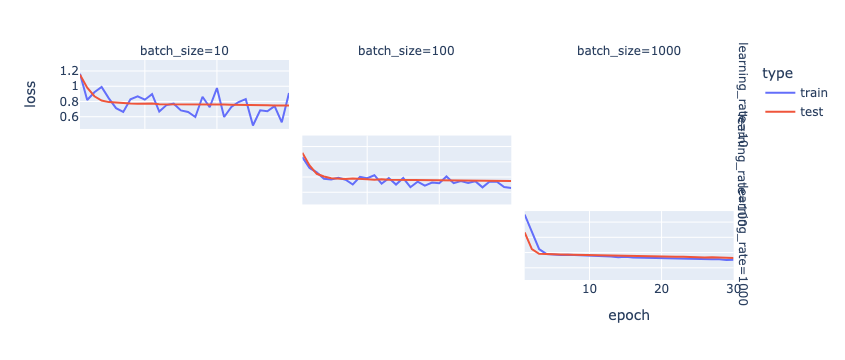

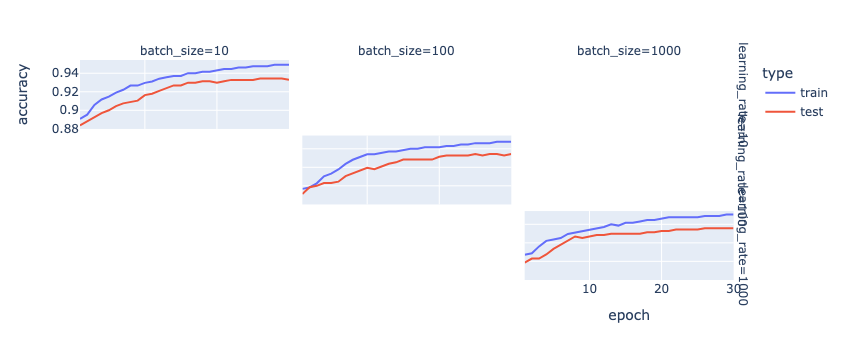

In [12]:
runs_df = pd.concat(results)

# plot training loss and test loss over time
px.line(
    runs_df,
    line_group="run_id",
    x="epoch",
    y="loss",
    color="type",
    hover_data=["batch_size", "learning_rate", "dropout_fraction"],
    facet_row="learning_rate",
    facet_col="batch_size",
    width=500,
).show()

# plot accuracy over time
px.line(
    runs_df,
    line_group="run_id",
    x="epoch",
    y="accuracy",
    color="type",
    hover_data=["batch_size", "learning_rate", "dropout_fraction"],
    facet_row="learning_rate",
    facet_col="batch_size",
    width=500,
).show()


## 8. Plot the before & after, showing the results of the best matrix found during training

The better the matrix is, the more cleanly it will separate the similar and dissimilar pairs.

In [13]:
# apply result of best run to original data
best_run = runs_df.sort_values(by="accuracy", ascending=False).iloc[0]
best_matrix = best_run["matrix"]
apply_matrix_to_embeddings_dataframe(best_matrix, df)


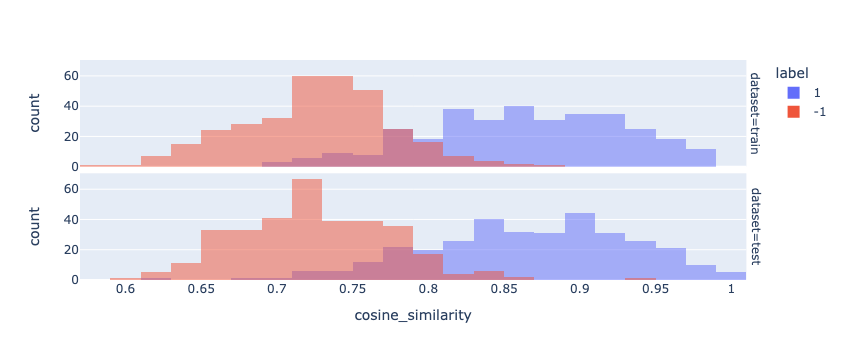

Test accuracy: 88.8% ± 2.4%


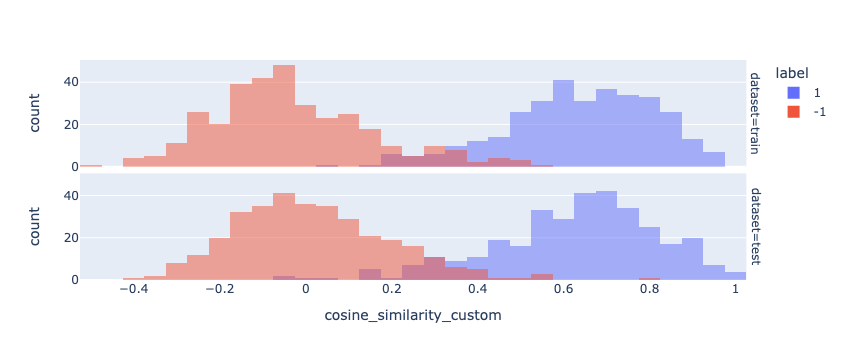

Test accuracy after customization: 93.6% ± 1.9%


In [14]:
# plot similarity distribution BEFORE customization
px.histogram(
    df,
    x="cosine_similarity",
    color="label",
    barmode="overlay",
    width=500,
    facet_row="dataset",
).show()

test_df = df[df["dataset"] == "test"]
a, se = accuracy_and_se(test_df["cosine_similarity"], test_df["label"])
print(f"Test accuracy: {a:0.1%} ± {1.96 * se:0.1%}")

# plot similarity distribution AFTER customization
px.histogram(
    df,
    x="cosine_similarity_custom",
    color="label",
    barmode="overlay",
    width=500,
    facet_row="dataset",
).show()

a, se = accuracy_and_se(test_df["cosine_similarity_custom"], test_df["label"])
print(f"Test accuracy after customization: {a:0.1%} ± {1.96 * se:0.1%}")


In [15]:
best_matrix  # this is what you can multiply your embeddings by


array([[-1.2566795e+00, -1.5297449e+00, -1.3271648e-01, ...,
        -1.2859761e+00, -5.3254390e-01,  4.8364732e-01],
       [-1.4826347e+00,  9.2656955e-02, -4.2437232e-01, ...,
         1.1872858e+00, -1.0831847e+00, -1.0683593e+00],
       [-2.2029283e+00, -1.9703420e+00,  3.1125939e-01, ...,
         2.2947595e+00,  5.5780332e-03, -6.0171342e-01],
       ...,
       [-1.1019799e-01,  1.3599515e+00, -4.7677776e-01, ...,
         6.5626711e-01,  7.2359240e-01,  3.0733588e+00],
       [ 1.6624762e-03,  4.2648423e-01, -1.1380885e+00, ...,
         8.7202555e-01,  9.3173909e-01, -1.6760436e+00],
       [ 7.7449006e-01,  4.9213606e-01,  3.5407653e-01, ...,
         1.3460466e+00, -1.9509128e-01,  7.7514690e-01]], dtype=float32)